# Neural Network using Dynamic Program solution as a startpoint

In [2]:
import numpy as np
import tensorflow as tf
import keras
from keras import layers
import torch
import torch.nn as nn
import torch.optim as optim
from scipy.stats import multivariate_normal


In [3]:
import numpy as np
from scipy.stats import multivariate_normal
def generate_normal_distribution(n):

    L = np.random.rand(n, n)
    cov_matrix = np.dot(L, L.T)

    mean = np.random.randn(n)
    print(mean)

    return [mean,cov_matrix]


n = 1
regimes = []
N = 2
T= 50
rf = 0.0154/50
gamma = -1
tpm = np.array([[0.981,0.019],[0.047,0.953]])
regimes = [[[0.00312],[[0.00022]]],[[-0.00175],[[0.00116]]]]

def generate_scenario(prob,t):
    current_regime = np.random.choice(N,p = prob)
    sample = list(np.random.multivariate_normal(mean = regimes[current_regime][0], cov= regimes[current_regime][1]))
    sample.append(rf)
    return np.array(sample)

def generate_monte_carlo_sample():
    sample = []
    curr_regime = np.random.choice(range(N))
    returns = list(np.random.multivariate_normal(mean = regimes[curr_regime][0], cov= regimes[curr_regime][1]))
    returns.append(rf)
    sample.append([curr_regime,returns])
    for i in range(T-1):
        curr_regime = np.random.choice(range(N), p = tpm[curr_regime])
        returns = list(np.random.multivariate_normal(mean = regimes[curr_regime][0], cov= regimes[curr_regime][1]))
        returns.append(rf)
        returns = np.array(returns)
        sample.append([curr_regime,returns])

    return sample


generate_monte_carlo_sample()

[[1, [0.08007781581325278, 0.000308]],
 [1, array([-0.00472471,  0.000308  ])],
 [1, array([0.02342877, 0.000308  ])],
 [1, array([-0.06924446,  0.000308  ])],
 [1, array([-0.04556195,  0.000308  ])],
 [1, array([-0.00683954,  0.000308  ])],
 [1, array([0.04197487, 0.000308  ])],
 [1, array([0.0056533, 0.000308 ])],
 [1, array([0.00548555, 0.000308  ])],
 [1, array([-0.02001591,  0.000308  ])],
 [1, array([0.01979011, 0.000308  ])],
 [1, array([-0.00806801,  0.000308  ])],
 [0, array([-0.0140968,  0.000308 ])],
 [0, array([0.01681309, 0.000308  ])],
 [0, array([-0.00225135,  0.000308  ])],
 [0, array([-0.00245717,  0.000308  ])],
 [0, array([-0.00486752,  0.000308  ])],
 [1, array([0.01388213, 0.000308  ])],
 [1, array([0.03110624, 0.000308  ])],
 [1, array([-0.0008986,  0.000308 ])],
 [0, array([0.02836125, 0.000308  ])],
 [0, array([-0.01414512,  0.000308  ])],
 [0, array([-0.02623265,  0.000308  ])],
 [0, array([-0.02057082,  0.000308  ])],
 [0, array([0.00505088, 0.000308  ])],
 [0

In [4]:
generate_scenario([1,0],0)


array([-0.013459,  0.000308])

In [5]:
print(regimes[1][:])

[[-0.00175], [[0.00116]]]


## Probabilty set initialization over different regimes

In [6]:
from itertools import product
from scipy.optimize import minimize

discrete_prob = 50
prob_set = []
for i in range(discrete_prob+1):
    prob_set.append(1/(discrete_prob)*i)

combinations = product(prob_set, repeat=N)
possible_probabities = [vector for vector in combinations if sum(vector) == 1]
reverse_index = {}
for _,p in enumerate(possible_probabities):
    reverse_index[p]= _

possible_probabities = [np.array(x) for x in possible_probabities]


In [7]:
delta_pi = 0.02
pi_set = []
curr_pi = -1
while curr_pi<=1+1e-5:
    pi_set.append(curr_pi)
    curr_pi+=delta_pi

pi_combinations = product(pi_set,repeat=n)
possible_pi = [np.append(np.array(vector),1-np.sum(vector)) for vector in pi_combinations]


In [8]:
print(possible_pi[-1])

[ 1.00000000e+00 -1.11022302e-15]


In [9]:
def closest_probability_distn(p_in):
    lowest_norm = np.array(float('inf'))
    ind = 0

    for _,array in enumerate(possible_probabities):
        norm = np.linalg.norm(p_in - array)
        if norm < lowest_norm:
            lowest_norm = norm
            closest_array = array
            ind = _

    return ind,closest_array

def updateBelief(r,p):
    r = r[:-1]
    density = np.array([multivariate_normal.pdf(r,mean = regimes[i][0], cov = regimes[i][1]) for i in range(N)])
    p_new = tpm.T@(density*p)
    p_new/=np.sum(p_new)
    
    closest_p_ind,_ = closest_probability_distn(p_new)
    return p_new,closest_p_ind

def newWealth(r, pi):
  return np.sum(pi*(1+r))

## Random path observation

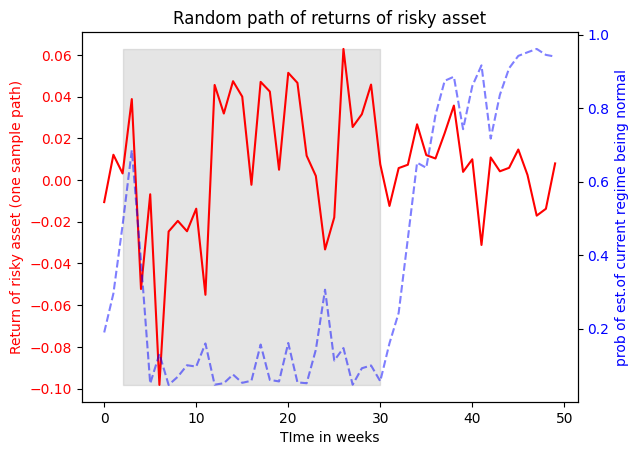

In [10]:
sample_returns = generate_monte_carlo_sample()

initial_belief = np.random.rand(N)
initial_belief/=np.sum(initial_belief)

belief_values = [initial_belief[0]]
prev_belief = initial_belief

for i in range(T):
    upd_belief,_ = updateBelief(sample_returns[i][1],prev_belief)
    belief_values.append(upd_belief[0])
    prev_belief = upd_belief

import matplotlib.pyplot as plt
x_values = [i for i in range(T)]
y_values = [array[1][0] for array in sample_returns]
regimes_for_this_sample = [array[0] for array in sample_returns]
fig,ax1 = plt.subplots()
ax1.plot(x_values,y_values,color = 'r')
ax1.fill_between(x_values,min(y_values),max(y_values),where = [regimes_for_this_sample[i]==1 for i in range(T)],color = 'grey',alpha = 0.2)
ax1.set_xlabel("TIme in weeks")
ax1.set_ylabel("Return of risky asset (one sample path)",color='r')
ax1.tick_params(axis = 'y',labelcolor = 'r')

ax2 = ax1.twinx()
ax2.set_ylabel('prob of est.of current regime being normal', color = 'b') 
ax2.plot(x_values, belief_values[:-1], color = 'b',linestyle ='--',alpha = 0.5)  
ax2.tick_params(axis = 'y',labelcolor = 'b')

plt.title("Random path of returns of risky asset")
plt.show()

## Loading dynamic programming results

In [11]:
import pickle

with open("Example1_DP_V_values.pkl", "rb") as fp:
    V = pickle.load(fp)

with open("Example1_DP_optimal_allocation.pkl", "rb") as fp:
    optimal_pi_star = pickle.load(fp)

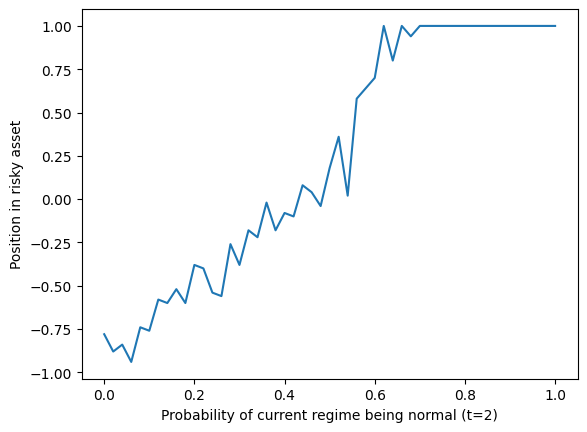

In [12]:
import matplotlib.pyplot as plt

xpoints = [x[0] for x in possible_probabities]
ypoints = [optimal_pi_star[_,2][0] for _ in range(len(possible_probabities))]

plt.plot(xpoints,ypoints)
plt.xlabel("Probability of current regime being normal (t=2)")
plt.ylabel("Position in risky asset")
plt.show()

#print([optimal_pi_star[_,0] for _ in range(5)])

# Neural Network Approach

C:\Users\91897\AppData\Local\Temp\ipykernel_12860\2711901114.py:29: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:264.)
  input_data = torch.tensor(input_data,dtype= torch.float32)
C:\Users\91897\AppData\Local\Temp\ipykernel_12860\2711901114.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  model_input_data = [[torch.tensor(input_data[i],requires_grad=True),


2541
25000


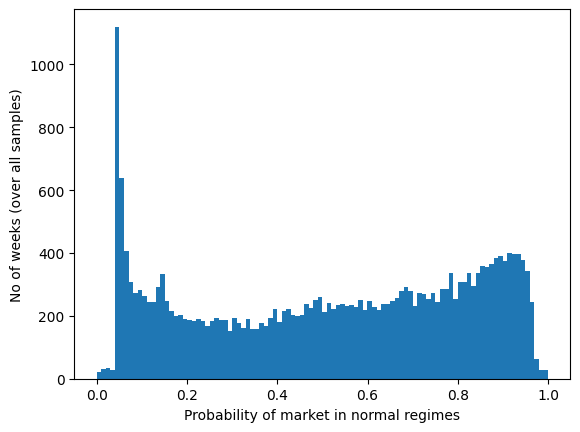

In [12]:
#Training data
T = 5
n_samples = 5000

input_data = []
return_samples= []
cnt0 = 0
plot_x = []
for i in range(n_samples):
    sample = generate_monte_carlo_sample()
    if(sample[0][0]==0):
        cnt0+=1
    returns_for_this_sample = []
    for time in range(T):
        returns_for_this_sample.append(sample[time][1])
    return_samples.append(returns_for_this_sample)
    #return_samples.append()
    initial_p = np.random.rand(N)
    initial_p/=np.sum(initial_p)
    plot_x.append(initial_p[0])
    input_to_rnn = [initial_p]
    for time in range(T-1):
        p = input_to_rnn[-1]
        p_new,___ = updateBelief(sample[time][1],p)
        #p_new = closest_probability_distn(p_new)[1]
        plot_x.append(p_new[0])
        input_to_rnn.append(p_new)
    input_data.append(input_to_rnn)
input_data = torch.tensor(input_data,dtype= torch.float32)

model_input_data = [[torch.tensor(input_data[i],requires_grad=True),
                     torch.tensor(1000.0,requires_grad=True),
                     torch.ones(n+1,requires_grad=True)/(n+1),
                     torch.tensor(return_samples[i],requires_grad = True)] for i in range(n_samples)]

print(cnt0)
print(len(plot_x))


import matplotlib.pyplot as plt
plt.hist(plot_x,bins = 100)
plt.xlabel("Probability of market in normal regimes")
plt.ylabel("No of weeks (over all samples)")
plt.show()

In [13]:
print(model_input_data[0])

[tensor([[0.7948, 0.2052],
        [0.8085, 0.1915],
        [0.6964, 0.3036],
        [0.8130, 0.1870],
        [0.0470, 0.9530]], requires_grad=True), tensor(1000., requires_grad=True), tensor([0.5000, 0.5000], grad_fn=<DivBackward0>), tensor([[ 0.0239,  0.0003],
        [-0.0239,  0.0003],
        [-0.0050,  0.0003],
        [-0.0920,  0.0003],
        [-0.0072,  0.0003]], dtype=torch.float64, requires_grad=True)]


In [13]:
from tqdm import tqdm

transaction_rate = 0.005


class CustomRNNCell(nn.Module):
    def __init__(self, input_size, output_size):
        super(CustomRNNCell, self).__init__()
        self.input_size = input_size
        self.output_size = output_size
        # self.rnn = nn.RNN(input_size, hidden_size = 2*output_size, num_layers = 1, batch_first=False)
        self.fc1 = nn.Sequential(
            nn.Linear(input_size, 20, bias=True),
            nn.Tanh(),  
            nn.Dropout(p= 0.2),
            nn.Linear(20, 40, bias=True),
            nn.Tanh(),  
            nn.Dropout(p = 0.2),
            nn.Linear(40, 80, bias=True),
            nn.Tanh(), 
            nn.Dropout(p = 0.2),
            nn.Linear(80, output_size,bias = True),
            nn.Sigmoid()
        )

        self.fc2 = nn.Sequential(
            nn.Linear(input_size, 20, bias=True),
            nn.Tanh(), 
            nn.Dropout(p = 0.2),
            nn.Linear(20, 40, bias=True),
            nn.Tanh(), 
            nn.Dropout(p = 0.2),
            nn.Linear(40, 80, bias=True),
            nn.Tanh(), 
            nn.Dropout(p = 0.2),
            nn.Linear(80, output_size, bias=True),
            nn.Sigmoid()
        )


    def forward(self, x):
        out_l = self.fc1(x)
        out_u = self.fc2(x)
        return out_l,out_u



class Model(nn.Module):
    def __init__(self, crra_coefficient,input_size,output_size):
        super(Model, self).__init__()
        self.crra_coefficient = crra_coefficient
        self.RNN  = CustomRNNCell(input_size,output_size)

    def forward(self, x):
        inputs_to_cell = x[0]
        inital_wealth = x[1]
        initial_portfolio = x[2]
        returns_sequence = x[3]

        wealth = [inital_wealth]
        portfolio = [initial_portfolio]
        pi_star_arrays = []

        for i in range(T):
            closest_p_ind,__ = closest_probability_distn(inputs_to_cell[i].detach().numpy())
            pi_star = torch.tensor(optimal_pi_star[(closest_p_ind,i)],requires_grad=True,dtype=torch.float32)
            pi_star_arrays.append(pi_star)

        lower_bounds = []
        upper_bounds = []

        for i in range(T):
            w = wealth[-1]
            pi = portfolio[-1]
            pi_new = pi[:-1]
            
            l_b,u_b = self.RNN(inputs_to_cell[i])
            l_b.retain_grad()
            u_b.retain_grad()

            
            u_b_clipped = torch.min(torch.ones(n),torch.add(pi_star_arrays[i][:-1],u_b))
            l_b_clipped = torch.max(-torch.ones(n),torch.add(pi_star_arrays[i][:-1],-l_b))
            lower_bounds.append(l_b_clipped)
            upper_bounds.append(u_b_clipped)
            pi_new = torch.max(l_b_clipped,torch.min(u_b_clipped,pi_new))  
            risk_free_allocation = torch.tensor(1.0)-torch.sum(pi_new)
            
            pi_new = torch.stack((pi_new.squeeze(),risk_free_allocation))

            new_wealth_after_rebalancing = torch.subtract(w,w*transaction_rate*torch.norm(pi-pi_new,p = 1))

            new_wealth_at_weekstart = new_wealth_after_rebalancing*torch.sum(torch.mul(pi_new,torch.add(torch.ones(n+1),returns_sequence[i])))
            pi_at_week_start = torch.mul(pi_new,torch.add(torch.ones(n+1),returns_sequence[i]))
            pi_at_week_start/= torch.sum(pi_at_week_start)
            
            wealth.append(new_wealth_at_weekstart)
            portfolio.append(pi_at_week_start)
            

        return portfolio,lower_bounds,upper_bounds,wealth




In [ ]:
crra_coefficient = -1
model = Model(crra_coefficient = crra_coefficient,input_size=N,output_size=n)

# from torchsummary import summary
# summary(model.RNN,(N,))
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

In [15]:

n_epochs = 50
loss_hist=[]
# Training Loop
for epoch in range(n_epochs):
  print("Epoch:",epoch)
  sz = 1
  avg_loss = 0
  for idx, X in tqdm(enumerate(model_input_data)):
   
    optimizer.zero_grad()
    portfolios,lower_bounds,upper_bounds,wealth = model(X)
    loss = -(wealth[-1]**crra_coefficient)/crra_coefficient
    loss.backward(
        retain_graph = True
    )
    #print(loss.grad)
    optimizer.step()

    avg_loss+= loss.item()
    sz+=1

  avg_loss/=sz
  loss_hist.append(avg_loss)
  print("Loss: ",avg_loss)

Epoch: 0


5000it [01:36, 51.81it/s]


Loss:  0.0009994448314637327
Epoch: 1


5000it [01:35, 52.17it/s]


Loss:  0.0009985617117685157
Epoch: 2


5000it [01:31, 54.92it/s]


Loss:  0.0009985351707233509
Epoch: 3


5000it [01:34, 52.74it/s]


Loss:  0.0009985313709256827
Epoch: 4


5000it [01:36, 52.01it/s]


Loss:  0.000998530668118969
Epoch: 5


5000it [01:35, 52.18it/s]


Loss:  0.0009985300444111654
Epoch: 6


5000it [01:37, 51.46it/s]


Loss:  0.0009985296084223567
Epoch: 7


5000it [01:37, 51.18it/s]


Loss:  0.0009985296354556247
Epoch: 8


5000it [01:37, 51.46it/s]


Loss:  0.0009985296280546013
Epoch: 9


5000it [01:36, 51.66it/s]


Loss:  0.0009985295923813698
Epoch: 10


5000it [01:37, 51.31it/s]


Loss:  0.0009985290817992446
Epoch: 11


5000it [01:36, 51.99it/s]


Loss:  0.0009985296926329672
Epoch: 12


5000it [01:36, 51.94it/s]


Loss:  0.000998529635573347
Epoch: 13


5000it [01:36, 51.84it/s]


Loss:  0.0009985295058620848
Epoch: 14


5000it [01:36, 51.89it/s]


Loss:  0.000998529495221152
Epoch: 15


5000it [01:35, 52.13it/s]


Loss:  0.0009985296185814113
Epoch: 16


5000it [01:36, 51.87it/s]


Loss:  0.0009985295552358154
Epoch: 17


5000it [01:36, 51.93it/s]


Loss:  0.0009985295725439952
Epoch: 18


5000it [01:38, 50.69it/s]


Loss:  0.0009985293834787695
Epoch: 19


5000it [01:36, 52.02it/s]


Loss:  0.0009985297141956256
Epoch: 20


5000it [01:36, 52.06it/s]


Loss:  0.0009985293240806728
Epoch: 21


5000it [01:36, 51.98it/s]


Loss:  0.0009985295262991169
Epoch: 22


5000it [01:37, 51.33it/s]


Loss:  0.0009985294912619091
Epoch: 23


5000it [01:39, 50.35it/s]


Loss:  0.00099852978974097
Epoch: 24


5000it [01:44, 47.88it/s]


Loss:  0.0009985296040797647
Epoch: 25


5000it [01:43, 48.31it/s]


Loss:  0.000998529533152155
Epoch: 26


5000it [01:49, 45.80it/s]


Loss:  0.0009985297208431989
Epoch: 27


5000it [01:38, 50.95it/s]


Loss:  0.0009985293090610397
Epoch: 28


5000it [01:36, 51.95it/s]


Loss:  0.0009985295401026312
Epoch: 29


5000it [01:37, 51.13it/s]


Loss:  0.0009985295968766707
Epoch: 30


5000it [01:38, 50.82it/s]


Loss:  0.0009985296235829459
Epoch: 31


5000it [01:37, 51.27it/s]


Loss:  0.000998529545255881
Epoch: 32


5000it [01:40, 49.62it/s]


Loss:  0.000998529356426604
Epoch: 33


5000it [01:38, 50.78it/s]


Loss:  0.0009985294082580918
Epoch: 34


5000it [01:43, 48.22it/s]


Loss:  0.0009985298042747693
Epoch: 35


5000it [01:42, 48.55it/s]


Loss:  0.0009985294168660466
Epoch: 36


5000it [01:40, 49.68it/s]


Loss:  0.0009985298146623753
Epoch: 37


5000it [01:39, 50.29it/s]


Loss:  0.0009985293795239454
Epoch: 38


5000it [01:37, 51.39it/s]


Loss:  0.0009985299696394427
Epoch: 39


5000it [01:35, 52.51it/s]


Loss:  0.0009985295768334935
Epoch: 40


5000it [01:35, 52.39it/s]


Loss:  0.0009985297365567142
Epoch: 41


5000it [01:35, 52.59it/s]


Loss:  0.0009985296747498822
Epoch: 42


5000it [01:35, 52.56it/s]


Loss:  0.0009985297454379494
Epoch: 43


5000it [01:36, 51.57it/s]


Loss:  0.0009985300376013579
Epoch: 44


5000it [01:34, 53.00it/s]


Loss:  0.0009985295237769738
Epoch: 45


5000it [01:36, 51.82it/s]


Loss:  0.0009985295468808012
Epoch: 46


5000it [01:34, 53.17it/s]


Loss:  0.0009985294889830424
Epoch: 47


5000it [01:33, 53.26it/s]


Loss:  0.000998529615492854
Epoch: 48


5000it [01:39, 50.28it/s]


Loss:  0.000998529341195277
Epoch: 49


5000it [01:31, 54.66it/s]

Loss:  0.0009985296484540831


SyntaxError: invalid syntax (667286001.py, line 4)

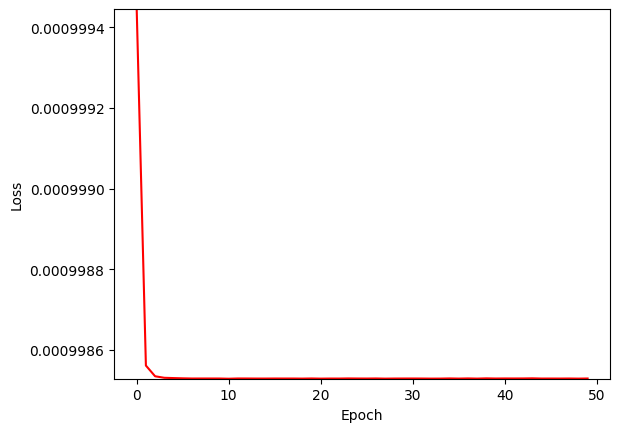

In [24]:
import matplotlib.pyplot as plt
plt.plot([epoch for epoch in range(n_epochs)],loss_hist,color = 'r')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [17]:
# Print model's state_dict
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

Model's state_dict:
RNN.fc1.0.weight 	 torch.Size([20, 2])
RNN.fc1.0.bias 	 torch.Size([20])
RNN.fc1.3.weight 	 torch.Size([40, 20])
RNN.fc1.3.bias 	 torch.Size([40])
RNN.fc1.6.weight 	 torch.Size([80, 40])
RNN.fc1.6.bias 	 torch.Size([80])
RNN.fc1.9.weight 	 torch.Size([1, 80])
RNN.fc1.9.bias 	 torch.Size([1])
RNN.fc2.0.weight 	 torch.Size([20, 2])
RNN.fc2.0.bias 	 torch.Size([20])
RNN.fc2.3.weight 	 torch.Size([40, 20])
RNN.fc2.3.bias 	 torch.Size([40])
RNN.fc2.6.weight 	 torch.Size([80, 40])
RNN.fc2.6.bias 	 torch.Size([80])
RNN.fc2.9.weight 	 torch.Size([1, 80])
RNN.fc2.9.bias 	 torch.Size([1])


[0. 1.] [0.91614723] [0.99999917]
[0.02 0.98] [0.8566756] [0.99999964]
[0.04 0.96] [0.80303943] [0.99999774]
[0.06 0.94] [0.87874216] [0.9999981]
[0.08 0.92] [0.90023535] [0.99999774]
[0.1 0.9] [0.9105935] [0.9999999]
[0.12 0.88] [0.89457846] [0.9999994]
[0.14 0.86] [0.84545857] [0.999998]
[0.16 0.84] [0.9144717] [0.9999981]
[0.18 0.82] [0.88554054] [0.9999987]
[0.2 0.8] [0.9081891] [0.9999988]
[0.22 0.78] [0.82256705] [0.99999595]
[0.24 0.76] [0.9012466] [0.99999726]
[0.26 0.74] [0.84602433] [0.9999988]
[0.28 0.72] [0.8863221] [0.99998915]
[0.3 0.7] [0.8652411] [0.9999958]
[0.32 0.68] [0.88467836] [0.9999958]
[0.34 0.66] [0.8856252] [0.9999994]
[0.36 0.64] [0.88240397] [0.9999987]
[0.38 0.62] [0.85158616] [0.9999962]
[0.4 0.6] [0.8782467] [0.9999993]
[0.42 0.58] [0.8730337] [0.99999976]
[0.44 0.56] [0.89454323] [0.9999994]
[0.46 0.54] [0.8980149] [0.9999975]
[0.48 0.52] [0.9077559] [0.9999995]
[0.5 0.5] [0.8427951] [0.99999595]
[0.52 0.48] [0.8883486] [0.9999994]
[0.54 0.46] [0.859781

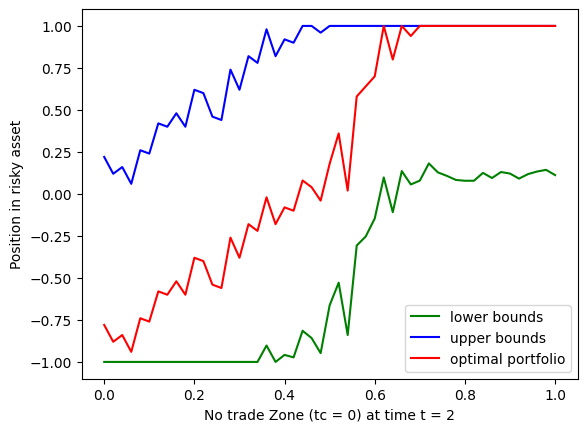

In [18]:
import matplotlib.pyplot as plt
x_values = []
upper_b = []
lower_b = []
portfolio_values = []
for p in possible_probabities:
    p_normal = p[0]
    x_values.append(p_normal)
    pi_star = optimal_pi_star[(reverse_index[tuple(p)],2)]
    portfolio_values.append(pi_star[0])
    l_b,u_b = model.RNN(torch.tensor(p,dtype = torch.float32))
    l_b = l_b.detach().numpy()
    u_b = u_b.detach().numpy()
    print(p,l_b,u_b)
    lower_b.append(max(-1.0,(pi_star[0]-l_b[0])))
    upper_b.append(min(1.0,(pi_star[0]+u_b[0])))

plt.plot(x_values,lower_b,color= 'g',label = 'lower bounds')
plt.plot(x_values,upper_b,color = 'b',label = 'upper bounds')
plt.plot(x_values,portfolio_values,color = 'r',label = 'optimal portfolio')
plt.xlabel('No trade Zone (tc = 0) at time t = 2')
plt.ylabel('Position in risky asset')
plt.legend()
plt.show()

In [19]:
torch.save(model.state_dict(), 'Example1_model_tc0.5')

In [20]:
model_Replica = Model(crra_coefficient = -1,input_size = N,output_size = n)
model_Replica.load_state_dict(torch.load('Example1_model_tc0.5'))

<All keys matched successfully>

## Test for a Random path

In [60]:
def generate_random_path(n_samples):
    input_data = []
    return_samples= []
    for i in range(n_samples):
        sample = generate_monte_carlo_sample()
        
        returns_for_this_sample = []
        for time in range(T):
            returns_for_this_sample.append(sample[time][1])
        return_samples.append(torch.tensor(returns_for_this_sample,dtype = torch.float32))
        
        initial_p = np.random.rand(N)
        initial_p/=np.sum(initial_p)
        plot_x.append(initial_p[0])
        
        input_to_rnn = [initial_p]
        for time in range(T-1):
            p = input_to_rnn[-1]
            p_new,___ = updateBelief(sample[time][1],p)
            #p_new = closest_probability_distn(p_new)[1]
            
            input_to_rnn.append(p_new)
        input_data.append(torch.tensor(input_to_rnn, dtype = torch.float32))

    return input_data,return_samples

random_path= generate_random_path(1)
random_beliefs, random_returns = random_path[0][0],random_path[1][0]
print(random_beliefs,random_returns)

tensor([[0.5857, 0.4143],
        [0.7427, 0.2573],
        [0.7246, 0.2754],
        [0.6934, 0.3066],
        [0.8048, 0.1952]]) tensor([[ 0.0123,  0.0003],
        [ 0.0268,  0.0003],
        [-0.0191,  0.0003],
        [-0.0062,  0.0003],
        [-0.0012,  0.0003]])


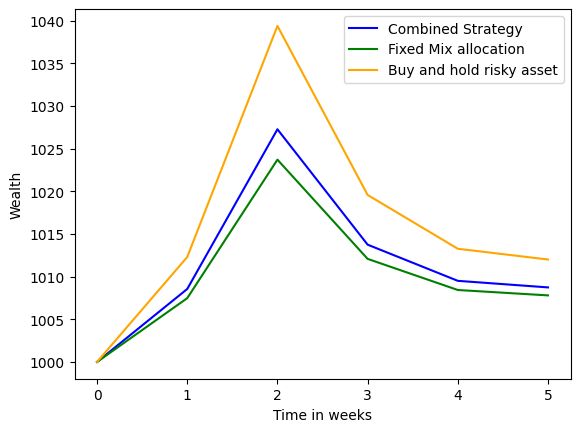

In [61]:
test_wealth = torch.tensor(1000.0)
test_inital_portfolio = torch.rand(n+1)
test_inital_portfolio = test_inital_portfolio/torch.sum(test_inital_portfolio)

values_from_rnn = model([random_beliefs,test_wealth,test_inital_portfolio,random_returns])
wealth_sample = [w.item() for w in values_from_rnn[-1]]


fixed_strategy = torch.tensor([0.6,0.4])
wealth_fixed_strategy = [1000]
for i in range(T):
    prev_wealth = wealth_fixed_strategy[-1]
    new_wealth = prev_wealth*torch.sum(torch.mul(fixed_strategy,1+random_returns[i]))
    curr_allocation = torch.mul(fixed_strategy,1+random_returns[i])
    curr_allocation/=torch.sum(curr_allocation)
    new_wealth -= transaction_rate*new_wealth*torch.norm(fixed_strategy-curr_allocation,p = 1)
    wealth_fixed_strategy.append(new_wealth)


wealth_buy_and_hold = [1000]
for i in range(T):
    prev_wealth = wealth_buy_and_hold[-1]
    new_wealth = prev_wealth*(1+random_returns[i][0]).item()
    wealth_buy_and_hold.append(new_wealth)

import matplotlib.pyplot as plt
plt.plot([i for i in range(T+1)],wealth_sample,color ='b',label = 'Combined Strategy')
plt.plot([i for i in range(T+1)],wealth_fixed_strategy,color ='g',label = 'Fixed Mix allocation')
plt.plot([i for i in range(T+1)],wealth_buy_and_hold,color ='orange',label = 'Buy and hold risky asset')
plt.xlabel("Time in weeks")
plt.ylabel("Wealth")
plt.legend()
plt.show()